In [11]:
"""
Load Shohei Ohtani’s 2023 Statcast batting data from the MLB database via the pybaseball API
This cell sets up the analysis by importing required libraries and pulling raw pitch-level data for the full season
The data will be used to analyze first pitch swing tendencies by pitch type
"""

# Import data manipulation libraries
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps

# Import Statcast data functions
from pybaseball import statcast_batter

# Configure display settings
%matplotlib inline
sns.set(style="whitegrid")

# Define Shohei Ohtani's player ID
ohtani_id = 660271

# Load 2023 Statcast batting data
batting_data = statcast_batter('2023-03-01', '2023-10-01', ohtani_id)

Gathering Player Data


In [28]:
"""
Define pitch type groupings for fastballs, breaking balls, and off-speed pitches
Also define the list of swing-related outcomes to identify swings from pitch descriptions
This will be used to calculate swing percentages in later analysis
"""

# Define pitch type buckets
pitch_buckets = {
    'Fastballs': ['FF', 'SI', 'FC'],
    'Breaking Balls': ['SL', 'CU', 'KC', 'SV', 'ST'],
    'Off-Speed': ['CH', 'FS', 'FO']
}

# Define what counts as a swing
swing_descriptions = [
    'swinging_strike', 'swinging_strike_blocked',
    'foul', 'foul_tip', 'foul_bunt',
    'hit_into_play', 'hit_into_play_score', 'hit_into_play_no_out'
]

In [29]:
"""
Filter the Statcast data to include only 0-0 counts (first pitch of a plate appearance)
Then further restrict to pitches that were located within the standardized strike zone
This subset is used to isolate in-zone swing behavior on the first pitch
"""

# Filter for 0-0 count
first_pitch_df = batting_data[(batting_data['balls'] == 0) & (batting_data['strikes'] == 0)].copy()

# Filter for pitches in the strike zone (Statcast standard zone)
in_zone_df = first_pitch_df[
    (first_pitch_df['plate_x'].abs() <= 0.83) & 
    (first_pitch_df['plate_z'] >= first_pitch_df['sz_bot']) &
    (first_pitch_df['plate_z'] <= first_pitch_df['sz_top'])
]


In [20]:
"""
Define a function to calculate in-zone swing percentage (Z-Swing%) for each pitch category
The function filters by pitch type, checks how many of those pitches were swung at, and returns percentages
Also includes an aggregate row for all pitch types combined
"""

# Function to compute Z-Swing% by pitch bucket
def z_swing_percentage(df, pitch_buckets, swing_descriptions):
    results = []

    for bucket, pitch_types in pitch_buckets.items():
        bucket_df = df[df['pitch_type'].isin(pitch_types)]
        total = len(bucket_df)
        swings = bucket_df['description'].isin(swing_descriptions).sum()
        swing_pct = (swings / total * 100) if total > 0 else np.nan
        results.append({'Pitch Type': bucket, 'Z-Swing %': swing_pct})

    # All pitch types
    total_all = len(df)
    swings_all = df['description'].isin(swing_descriptions).sum()
    swing_pct_all = (swings_all / total_all * 100) if total_all > 0 else np.nan
    results.append({'Pitch Type': 'All Pitch Types', 'Z-Swing %': swing_pct_all})

    return pd.DataFrame(results)

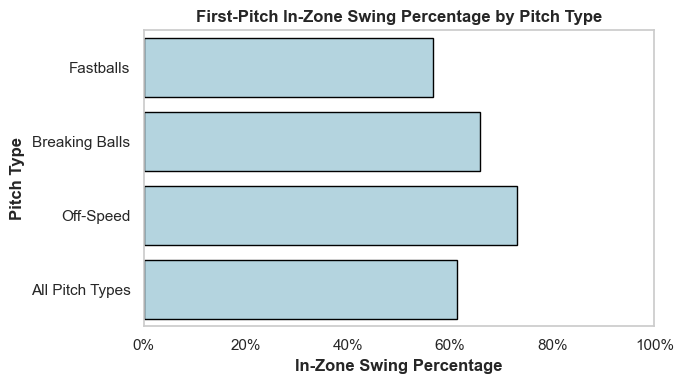

In [ ]:
"""
Calculate and visualize in-zone swing percentage (Z-Swing%) on first pitches for each pitch group
Generates a horizontal bar chart using Seaborn with pale blue bars and clean formatting
This visualization shows how often Ohtani swings at hittable first pitches based on pitch type
"""

from matplotlib.ticker import PercentFormatter

# Calculate and plot
z_swing_data = z_swing_percentage(in_zone_df, pitch_buckets, swing_descriptions)

# Set font globally to Arial
plt.rcParams['font.family'] = 'Arial'

# Plotting
plt.figure(figsize=(7, 4))

# Pale blue with skinny black edge
sns.barplot(
    data=z_swing_data,
    y='Pitch Type',
    x='Z-Swing %',
    color='#add8e6',  # pale blue
    edgecolor='black'
)

# Title and labels
plt.title("First-Pitch In-Zone Swing Percentage by Pitch Type", weight='bold')
plt.xlim(0, 100)
plt.xlabel("In-Zone Swing Percentage", weight='bold')
plt.ylabel("Pitch Type", weight='bold')

# Format X-axis as percentages
plt.gca().xaxis.set_major_formatter(PercentFormatter())

# Remove gridlines but keep axes
plt.grid(False)

# Save and show
plt.tight_layout()
#plt.savefig("ohtani_zswing_horizontal.png", dpi=300, bbox_inches='tight')
plt.show()